# [NTDS'19] assignment 1: network science
[ntds'19]: https://github.com/mdeff/ntds_2019

[Eda Bayram](https://lts4.epfl.ch/bayram), [EPFL LTS4](https://lts4.epfl.ch) and
[Nikolaos Karalias](https://people.epfl.ch/nikolaos.karalias), [EPFL LTS2](https://lts2.epfl.ch).

## Students

* Team: `<your team number>`
* Students: `<your name`> (for the indivudual submission) or `<the name of all students in the team>` (for the team submission)

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

The purpose of this milestone is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

## Cora Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/node/236) consists of scientific publications classified into one of seven research fields. 

* **Citation graph:** the citation network can be constructed from the connections given in the `cora.cites` file.
* **Feature graph:** each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in the `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed using the Euclidean distance between the feature vector of the publications.

The [`README`](data/cora/README) provides details about the content of [`cora.cites`](data/cora/cora.cites) and [`cora.content`](data/cora/cora.content).

## Section 1: Network Properties

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Question 1: Construct a Citation Graph and a Feature Graph

Read the `cora.content` file into a Pandas DataFrame by setting a header for the column names. Check the `README` file.

In [2]:
column_list = list(np.arange(1433))
column_list.append('class_label')
column_list.insert(0, 'paper_id')
pd_content = pd.read_csv('data/cora/cora.content', delimiter='\t', names=column_list) 
pd_content.head()

,paper_id,0,1,2,3,4,5,6,7,8,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,class_label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use the `value_counts()` function.

In [3]:
pd_content['class_label'].value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: class_label, dtype: int64

Select all papers from a field of your choice and store their feature vectors into a NumPy array.
Check its shape.

In [4]:
my_field = 'Probabilistic_Methods'
features = pd_content[pd_content['class_label']==my_field]
features = features.drop(columns=['class_label', 'paper_id'])
features = features.values
features.shape

(426, 1433)

Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a Numpy array. 

In [5]:
distance = np.zeros((features.shape[0],features.shape[0]))
for i in range(len(features)):
    for j in range(len(features)):
        distance[i,j] = np.linalg.norm(features[i]-features[j])
distance.shape

(426, 426)

Check the mean pairwise distance $\mathbb{E}[D]$.

In [6]:
mean_distance = distance.mean()
mean_distance

5.790575729028696

Plot an histogram of the euclidean distances.

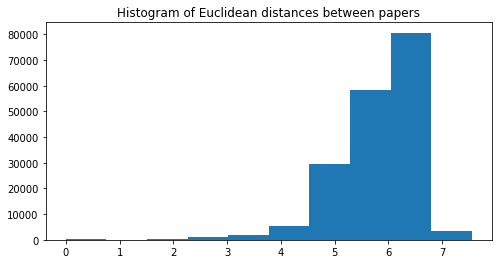

In [7]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance.flatten());

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries
$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

In [8]:
threshold = mean_distance
A_feature = np.zeros((features.shape[0],features.shape[0]))
for i in range(features.shape[0]):
    for j in [x for x in range(features.shape[0]) if x!=i]:
        if distance[i,j] < threshold:
            A_feature[i,j] = 1

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix.

In [9]:
cora_cites = np.genfromtxt('data/cora/cora.cites', delimiter='\t')
citation_dict = dict(zip(pd_content['paper_id'], range(len(pd_content))))
A_citation = np.zeros((len(pd_content),len(pd_content)))
for i in cora_cites:
    A_citation[citation_dict[i[1]], citation_dict[i[0]]] = 1
    A_citation[citation_dict[i[0]], citation_dict[i[1]]] = 1
A_citation.shape

(2708, 2708)

Get the adjacency matrix of the citation graph for the field that you chose.
You have to appropriately reduce the adjacency matrix of the citation graph.

In [10]:
A_citation = np.zeros((features.shape[0],features.shape[0]))
field_paper_id = pd_content[pd_content['class_label']==my_field]['paper_id'].values
citation_dict = dict(zip(field_paper_id, range(len(field_paper_id))))
for i in cora_cites:
    if i[0] in field_paper_id and i[1] in field_paper_id:
        A_citation[citation_dict[i[0]], citation_dict[i[1]]] = 1
        A_citation[citation_dict[i[1]], citation_dict[i[0]]] = 1
A_citation.shape

(426, 426)

Check if your adjacency matrix is symmetric. Symmetrize your final adjacency matrix if it's not already symmetric.

In [11]:
# Your code here.
np.count_nonzero(A_citation - A_citation.transpose())

0

Check the shape of your adjacency matrix again.

In [12]:
A_citation.shape

(426, 426)

### Question 2: Degree Distribution and Moments

What is the total number of edges in each graph?

In [13]:
num_edges_feature = sum(sum(A_feature))/2
num_edges_citation = sum(sum(A_citation))/2
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 34695.0
Number of edges in the citation graph: 660.0


Plot the degree distribution histogram for each of the graphs.

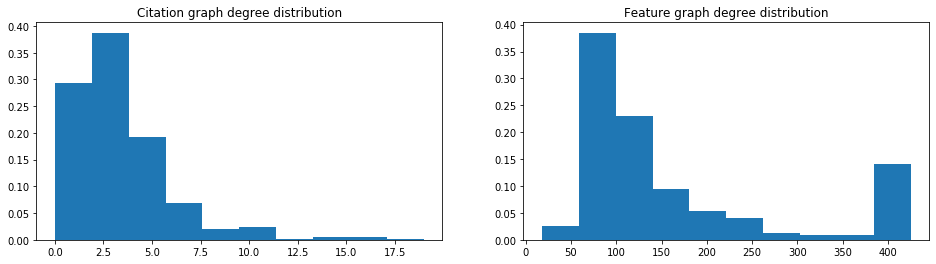

In [14]:
degrees_citation = np.array([sum(i) for i in A_citation])
degrees_feature = np.array([sum(i) for i in A_feature])

deg_hist_normalization = np.ones(degrees_citation.shape[0]) / degrees_citation.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(degrees_citation, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(degrees_feature, weights=deg_hist_normalization);

Calculate the first and second moments of the degree distribution of each graph.

In [15]:
cit_moment_1 = sum(degrees_citation)/features.shape[0]
cit_moment_2 = sum(degrees_citation*degrees_citation)/features.shape[0]

feat_moment_1 = sum(degrees_feature)/features.shape[0]
feat_moment_2 = sum(degrees_feature*degrees_feature)/features.shape[0]

print(f"1st moment of citation graph: {cit_moment_1}")
print(f"2nd moment of citation graph: {cit_moment_2}")
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of citation graph: 3.0985915492957745
2nd moment of citation graph: 16.6056338028169
1st moment of feature graph: 162.88732394366198
2nd moment of feature graph: 40686.17840375587


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

**Your answer here:**

Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

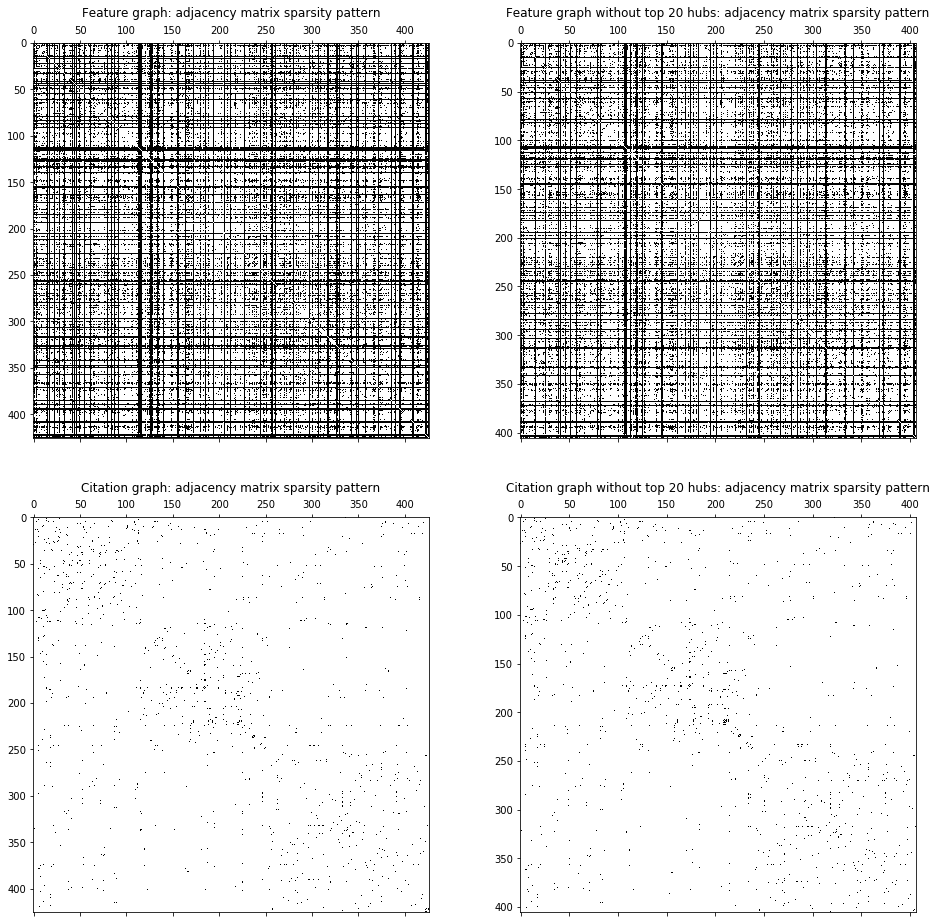

In [16]:
hub_index_feature = [index for index, value in sorted(enumerate(degrees_feature), reverse=True, key=lambda x: x[1])][:20]
hub_index_citation = [index for index, value in sorted(enumerate(degrees_citation), reverse=True, key=lambda x: x[1])][:20]
reduced_A_feature = np.delete(A_feature, hub_index_feature, axis = 0)
reduced_A_feature = np.delete(reduced_A_feature, hub_index_feature, axis = 1)
reduced_A_citation = np.delete(A_citation, hub_index_feature, axis = 0) 
reduced_A_citation = np.delete(reduced_A_citation, hub_index_feature, axis = 1)

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0, 0].spy(A_feature);
axes[0, 1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[0, 1].spy(reduced_A_feature);
axes[1, 0].set_title('Citation graph: adjacency matrix sparsity pattern')
axes[1, 0].spy(A_citation);
axes[1, 1].set_title('Citation graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1, 1].spy(reduced_A_citation);

Plot the new degree distribution histograms.

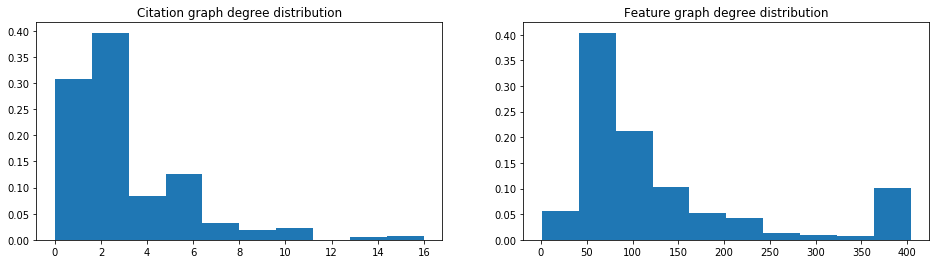

In [17]:
reduced_degrees_feat = np.array([sum(i) for i in reduced_A_feature])
reduced_degrees_cit = np.array([sum(i) for i in reduced_A_citation])

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0])/reduced_degrees_feat.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(reduced_degrees_cit, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(reduced_degrees_feat, weights=deg_hist_normalization);

Compute the first and second moments for the new graphs.

In [19]:
reduced_cit_moment_1 = sum(reduced_degrees_feat)/features.shape[0]
reduced_cit_moment_2 = sum(reduced_degrees_feat*reduced_degrees_feat)/features.shape[0]

reduced_feat_moment_1 = sum(reduced_degrees_cit)/features.shape[0]
reduced_feat_moment_2 = sum(reduced_degrees_cit*reduced_degrees_cit)/features.shape[0]


print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Citation graph first moment: 123.88732394366197
Citation graph second moment: 26875.671361502347
Feature graph first moment:  2.868544600938967
Feature graph second moment:  14.95774647887324


Print the number of edges in the reduced graphs.

In [20]:
print("Number of edges in the reduced citation graph:", sum(sum(reduced_A_citation))/2)
print("Number of edges in the reduced feature graph:", sum(sum(reduced_A_feature))/2)

Number of edges in the reduced citation graph: 611.0
Number of edges in the reduced feature graph: 26388.0


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

**Your answer here:**

### Question 3: Pruning, sparsity, paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [21]:
threshold = 3

A_feature_pruned = np.array(distance < threshold).astype(int)
np.fill_diagonal(A_feature_pruned,0)
num_edges_feature_pruned = sum(sum(A_feature_pruned))/2

print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the feature graph after pruning: {num_edges_feature_pruned}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 34695.0
Number of edges in the feature graph after pruning: 505.0
Number of edges in the citation graph: 660.0


Check your results by comparing the sparsity patterns and total number of edges between the graphs.

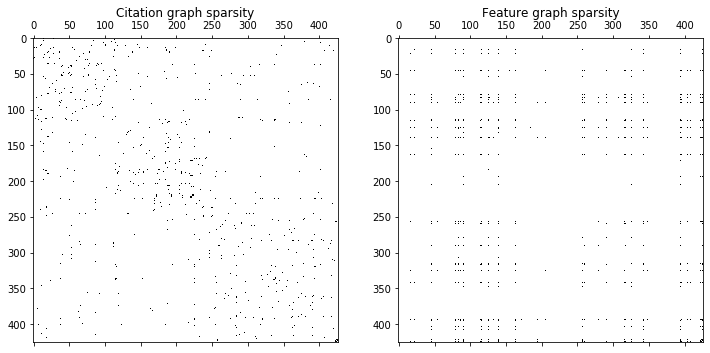

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Citation graph sparsity')
axes[0].spy(A_citation);
axes[1].set_title('Feature graph sparsity')
axes[1].spy(A_feature_pruned);

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j). $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  

**Hint:** Use [powers of the adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [23]:
path_matrix_citation = sum([np.linalg.matrix_power(A_citation, n ) for n in range(11)])
path_matrix_feature = sum([np.linalg.matrix_power(A_feature, n ) for n in range(11)])

Check the sparsity pattern for both of path matrices.

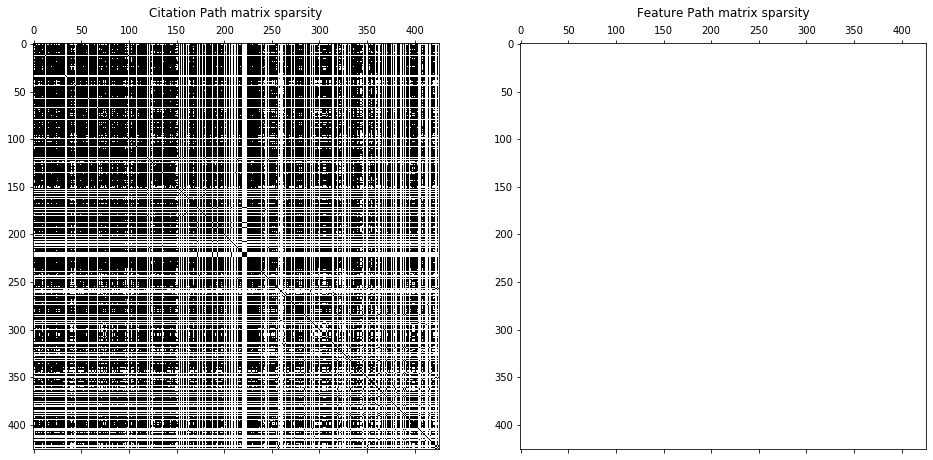

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].set_title('Citation Path matrix sparsity')
axes[0].spy(path_matrix_citation);
axes[1].set_title('Feature Path matrix sparsity')
axes[1].spy(path_matrix_feature);

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

[[          1           0           0 ...           0           0
            0]
 [          0           1           0 ...           0           0
            0]
 [          0           0           1 ...           0           0
            0]
 ...
 [          0           0           0 ...  -760855309           0
  -1185368660]
 [          0           0           0 ...           0           1
            0]
 [          0           0           0 ... -1185368660           0
   -256687375]]


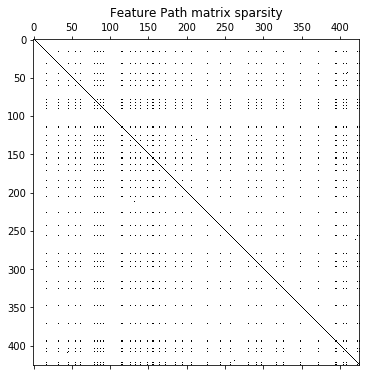

In [33]:
path_matrix_pruned = sum([np.linalg.matrix_power(A_feature_pruned, n ) for n in range(11)])

plt.figure(figsize=(12, 6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Your answer here:**

Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**Your answer here:** 

If the graph is connected, how can you guess its diameter using the path matrix?

**Your answer here:**

If any of your graphs is connected, calculate the diameter using that process.

In [50]:
# The connected graph is path_matrix_feature
for n in range(11):
    if 0 in np.linalg.matrix_power(A_feature, n ):
        continue   
    break
diameter = n
print(f"The diameter is: {diameter}")

The diameter is: 2


Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html).
Note: usage of NetworkX is only allowed in this part of Section 1.

In [51]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)
print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

Diameter according to networkx: 2


## Section 2: Network Models

In this section, you will analyze the feature and citation graphs you constructed in the previous section in terms of the network model types.
For this purpose, you can use the NetworkX libary imported below.

In [52]:
import networkx as nx

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section.

In [53]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))

Number of nodes: 426, Number of edges: 660
Number of self-loops: 0, Number of connected components: 48


In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [54]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))

Number of nodes: 426, Number of edges: 505
Number of self-loops: 0, Number of connected components: 373


### Question 4: Simulation with Erdős–Rényi and Barabási–Albert models

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation and feature graphs.

In [48]:
assert len(G_citation.nodes()) == len(G_feature.nodes())
n = len(G_citation.nodes())
n

426

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [49]:
m = np.round((G_citation.size() + G_feature.size()) / 2)
m

582.0

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here:**

In [ ]:
p = # Your code here.
G_er = nx.erdos_renyi_graph(n, p)

Check the number of edges in the Erdős–Rényi graph.

In [ ]:
print('My Erdos-Rényi network that simulates the citation graph has {} edges.'.format(G_er.size()))

How do you determine the preferential attachment parameter for Barabási–Albert graphs?

**Your answer here:**

In [ ]:
q = # Your code here.
G_ba = nx.barabasi_albert_graph(n, q)

Check the number of edges in the Barabási–Albert graph.

In [ ]:
print('My Barabási-Albert network that simulates the citation graph has {} edges.'.format(G_ba.size()))

### Question 5: Giant Component

Check the size of the largest connected component in the citation and feature graphs.

In [ ]:
giant_citation = # Your code here.
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

In [ ]:
giant_feature = # Your code here.
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

Check the size of the giant components in the generated Erdős–Rényi graph.

In [ ]:
giant_er = # Your code here.
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

**Hint:** Recall the expected giant component size from the lectures.

**Your answer here:**

In [ ]:
p_new = # Your code here.
G_er_new = nx.erdos_renyi_graph(n, p_new)

Check the size of the new Erdős–Rényi network and its giant component.

In [ ]:
print('My new Erdos Renyi network that simulates the citation graph has {} edges.'.format(G_er_new.size()))
giant_er_new = # Your code here.
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

### Question 6: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Citation graph')
citation_degrees = # Your code here.
axes[0].hist(citation_degrees);
axes[1].set_title('Feature graph')
feature_degrees = # Your code here.
axes[1].hist(feature_degrees);

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions?

**Your answer here:**

Now, plot the degree distribution historgrams for the simulated networks.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].set_title('Erdos-Rényi network')
er_degrees = # Your code here.
axes[0].hist(er_degrees);
axes[1].set_title('Barabási-Albert network')
ba_degrees = # Your code here.
axes[1].hist(ba_degrees);
axes[2].set_title('new Erdos-Rényi network')
er_new_degrees = # Your code here.
axes[2].hist(er_new_degrees);

In terms of the degree distribution, is there a good match between the citation and feature graphs and the simulated networks?
For the citation graph, choose one of the simulated networks above that match its degree distribution best. Indicate your preference below.

**Your answer here:** 

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [ ]:
G_config = nx.configuration_model(feature_degrees) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**Your answer here:** 

### Question 7: Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [ ]:
nx.average_clustering(G_citation)

In [ ]:
nx.average_clustering(G_feature)

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

**Your answer here:**

Now, let us check the average clustering coefficient for the simulated networks.

In [ ]:
nx.average_clustering(G_er)

In [ ]:
nx.average_clustering(G_ba)

In [ ]:
nx.average_clustering(nx.Graph(G_config))

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here:**

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here:**

If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

In [ ]:
# Your code here.

Comment on the similarities of your match.

**Your answer here:**